# Dynamical networks: dynamics of networks



Notebook for the 4th course of Big data CRI (2019). 

We use several libraries for this course:
`networkx`, `matplotlib`.


Importantly we will also create new classes and write new functions ourselves.

In [13]:
from collections import Counter
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap

#import watermark



Let us start with simple network on which we consider some processes.
We start with Erdos-Renyi graph.

In [19]:
#create new class Graph 

class Graph:
    def __init__(self, directed=False):
        self._nodes = {}
        self._edges = {}
        self._directed = directed

#adding methods to this class

def add_method(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

@add_method(Graph)
def add_node(self, node, **kwargs):
    self._nodes[node] = kwargs    
    
@add_method(Graph)
def add_nodes_from(self, nodes, **kwargs):
    for node in nodes:
        if isinstance(node, tuple):
            self._nodes[node[0]] = node[1:]
        else:
            self._nodes[node] = kwargs    
        
@add_method(Graph)
def nodes(self):
    return list(self._nodes.keys())        



@add_method(Graph)
def add_edge(self, node_i, node_j, **kwargs):
    if node_i not in self._nodes:
        self.add_node(node_i)
    
    if node_j not in self._nodes:
        self.add_node(node_j)
    
    if node_i not in self._edges:
        self._edges[node_i] = {}
        
    if node_j not in self._edges[node_i]:
        self._edges[node_i][node_j] = {}
        
    self._edges[node_i][node_j] = kwargs
    
    if not self._directed:
        if node_j not in self._edges:
            self._edges[node_j] = {}

        if node_i not in self._edges[node_j]:
            self._edges[node_j][node_i] = {}

        self._edges[node_j][node_i] = kwargs
        
        
@add_method(Graph)
def add_edges_from(self, edges, **kwargs):
    for edge in edges:
        self.add_edge(*edge, **kwargs)
        
        
@add_method(Graph)
def degree_distribution(self, normalize=True):
    deg = self.degrees()
    dist = Graph._build_distribution(deg, normalize)
    
    return dist      

@add_method(Graph)
def degrees(self):
    deg = {}
    
    for node in self._nodes:
        if node in self._edges:
            deg[node] =  len(self._edges[node])
        else:
            deg[node] = 0
    
    return deg


@add_method(Graph)
def _build_distribution(data, normalize=True):
    values = data.values()
    dist = list(Counter(values).items())
    dist.sort(key=lambda x:x[0])
    dist = np.array(dist, dtype='float')
           
    if normalize:
        norm = dist.T[1].sum()
        dist.T[1] /= norm
    
    return dist

# Different classes of networks

Importantly we can not just call networks from existing classes in ´networkx´ but also create these classes ourselves. Here we show examples from ER and Barabasi-Albert models. 

# Excercise 1 

Write class of network model yourself. Take any existing class in the library networkx.github.io/ 
e.g. 
1. lattice network 
2. watts-strogatz network

In [21]:
#@add_method(Graph) # we can add methods to new class as in https://github.com/Dataforscience/networks


@add_method(Graph)
def erdos_renyi_graph(N, p):
    nodes = list(range(N))
    edges = []
    
    for i in range(N):
        for j in range(i+1, N):
            if np.random.random() < p:
                edges.append((i, j))
    
    G = Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G

@add_method(Graph)
def barabasi_albert_graph(N):
    G = Graph()

    nodes = range(N)
    G.add_nodes_from(nodes)

    edges = [0,1,1,2,2,0]

    for node_i in range(3, N):
        pos = np.random.randint(len(edges))
        node_j = edges[pos]

        edges.append(node_i)
        edges.append(node_j)

    edges = zip(nodes, edges[1::2])

    G.add_edges_from(edges)

    return G

ER1 = Graph.erdos_renyi_graph(100, 0.1)


# Add methods 
Spreading processes on networks

In [33]:
#add method to Graph class

@add_method(Graph)
def number_of_edges(self):
    n_edges = 0
    
    for node_i in self._edges:
        n_edges += len(self._edges[node_i])
    
    # If the graph is undirected, don't double count the edges
    if not self._directed:
        n_edges /= 2
    
    return n_edges


@add_method(Graph)
def neighbours(self, node):
    if node in self._edges:
        return list(self._edges[node].keys())
    else:
        return []

    
@add_method(Graph)
def viral(self, beta, timesteps, seed):
    '''
    parameters of viral spreading:
    beta - parameter of spreading, probability 
    timesteps - number of steps of spreading
    '''
    
    N = len(self._nodes)

    configuration = np.zeros((timesteps, N), dtype='int')
    configuration[0, seed] = 1

    for t in range(0, timesteps-1):
        configuration[t+1] = np.copy(configuration[t])

        for i in range(N):
            if configuration[t][i] == 1:
                for neighbour in self.neighbours(i):
                    if configuration[t][neighbour] == 0:
                        prob = np.random.random()

                        if prob < beta:
                            configuration[t+1][neighbour] = 1

                        break

    return configuration

In [30]:


#WS = Graph.watts_strogatz_graph(100, 4, 0.02)
ER1 = Graph.erdos_renyi_graph(100, 0.1)
ER2 = Graph.erdos_renyi_graph(100, 0.5)
#ER1.number_of_edges()



# Drawing networks 

In [48]:
import networkx as nx 

########## plot setup ############

ns = 175 # node size##############
cols = ["#c77739","#9765ca","#40a0e2","#c95980","#01bb96"]
cols = ["#927134","#9765ca","#40a0e2","#c95980","#01bb96"]
cols = ["#666666","#666666","#666666","#666666","#666666"]
cols = ["#b03e61","#aa592a","#588435","#6172cc","#814192"]

##################################


def visual_network(G_th):
    pos = nx.kamada_kawai_layout(G_th)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.axis('off')
    #print(ind)
    nx.draw_networkx_nodes(G_th, pos, node_color='white', 
                       node_size=ns, linewidths=3.9,
                       alpha=0.98).set_edgecolor(cols[2])
    nx.draw_networkx_edges(G_th, pos, edge_color="#333333",
                       width=2.95, alpha=0.98)
    #plt.savefig('net_'+str(name_graph)+'.png')
    plt.show()   

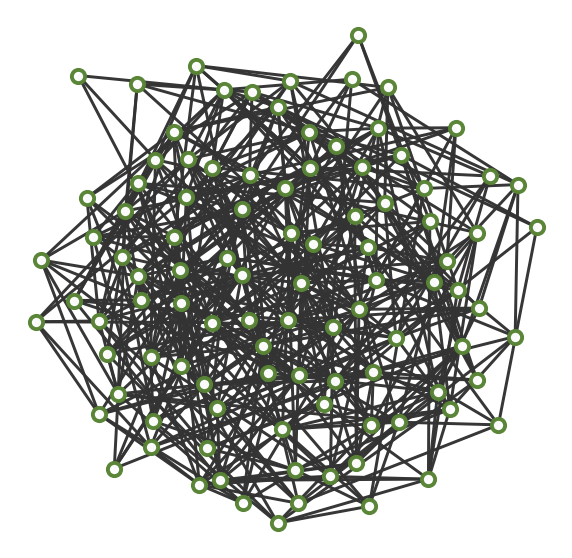

In [51]:
#set parameters of network 
N = 100
p = 0.1
G_ER_nx = nx.erdos_renyi_graph(N, p)

#visualise a network
visual_network(G_ER_nx)

# Properties of networks
We can now create classes to study properties of networks.

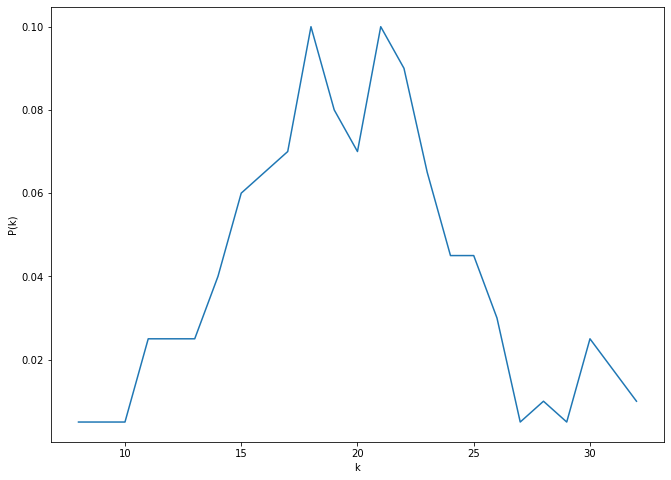

In [7]:
# we first start with looking at degree distributions

ER = Graph.erdos_renyi_graph(200, 0.1)
Pk = ER.degree_distribution()

plt.plot(Pk.T[0], Pk.T[1])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.gcf().set_size_inches(11, 8)


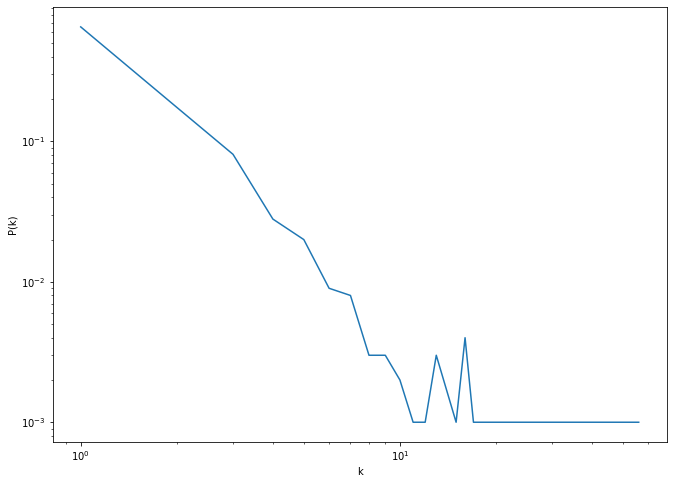

In [8]:
BA = Graph.barabasi_albert_graph(1000)
Pk = BA.degree_distribution()

plt.loglog(Pk.T[0], Pk.T[1])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.gcf().set_size_inches(11, 8)

In [9]:
# in order to use network properties in other notebooks


def export_class(path, filename):
    import io
    from nbformat import read

    with io.open(path, 'r', encoding='utf-8') as f:
        nb = read(f, 4)

    fp = open(filename, "wt")

    for cell in nb.cells:
        if cell.cell_type == 'code':
            first_line = cell.source.split('\n')[0]
            
            if "class " in first_line or "add_method" in first_line:
                print(cell.source, file=fp)

                print("\n", file=fp)
            elif "import" in first_line:
                for line in cell.source.split('\n'):
                    if not line.startswith("%"):
                        print(line.strip(), file=fp)
                        
                print("\n", file=fp)

    fp.close()
    
    
#we export Graph class to use it in other notebooks # see Love to Jupyter    
export_class('dynamical_networks.ipynb', 'Graph.py')    